#  dependencies

In [32]:
import os
from pathlib import Path
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import librosa, librosa.display
import pywt
from pydub import AudioSegment
import shutil
from scipy.signal import butter, lfilter
import wave
import soundfile as sf

# data loading

In [2]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
event_level=[]
file_name=[]
files=os.listdir(label_file)
records=pd.DataFrame(columns=['Path','record_annotation'])
events=pd.DataFrame(columns=['Path','start','end','type'])
for i in files:
    labels=json.load(open(os.path.join(label_file,i)))
    file_name={'Path':Path(i).stem+'.wav'}
    labels.update(file_name) 
    records.loc[len(records.index)]=labels
    event_level=labels['event_annotation']
    if len(event_level)==0:
        file_name.update({'type':'Poor Quality'})
        events.loc[len(events.index)]=file_name
    for x in range(0,len(event_level)):
        event_level[x].update(file_name)
        events.loc[len(events.index)]=event_level[x]

In [33]:
event_encode={"Normal":0,"Fine Crackle":1,"Wheeze":1,"Coarse Crackle":1,"Rhonchi":1,"Wheeze+Crackle":1,"Stridor":1,"Poor Quality":2}
pd.set_option('future.no_silent_downcasting', True)
encoded_event = events.replace({"type": event_encode}).infer_objects(copy=False)
record_encode={"Normal":0,"DAS":1,"CAS":1,"CAS & DAS":1,"Poor Quality":2}
encoded_record = records.replace({"record_annotation": record_encode}).infer_objects(copy=False)

***droping poor quality***

In [34]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
records=pd.read_csv(os.path.join('/kaggle/input/output/records.csv'),index_col=[0])
events=pd.read_csv(os.path.join('/kaggle/input/output/events.csv'),index_col=[0])

In [35]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)

In [36]:
events.drop(events[events['type']==0].index[2868:],inplace=True)
events.reset_index(drop=True, inplace=True)

type
0    50.0
1    50.0
Name: proportion, dtype: float64

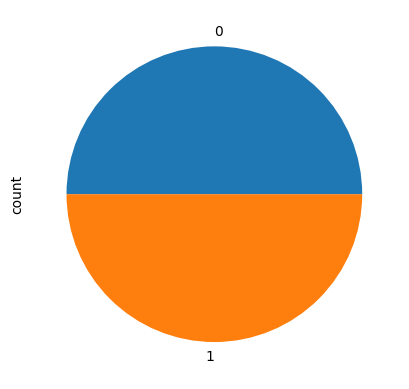

In [37]:
events['type'].value_counts().plot(kind="pie")
events['type'].value_counts(normalize=True)*100

***making nesscary directories***

In [7]:
# If the directory doesn't exist, create it
if not os.path.exists("fft"):    
    os.mkdir("fft")
if not os.path.exists("stft"):
    os.mkdir("stft")
if not os.path.exists("log_stft"):
    os.mkdir("log_stft")
if not os.path.exists("mel_spec"):
    os.mkdir("mel_spec")
if not os.path.exists("log_mel"):
    os.mkdir("log_mel")
if not os.path.exists("mfcc"):
    os.mkdir("mfcc")
if not os.path.exists("disc_wavelet"):
    os.mkdir("disc_wavelet")
if not os.path.exists("cont_wavelet"):
    os.mkdir("cont_wavelet")
if not os.path.exists("events"):
    os.makedirs("events")
if not os.path.exists("processed"):
    os.makedirs("processed")

***band pass filter***

In [38]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Define your lowcut and highcut frequencies
lowcut = 60.0
highcut = 1300.0

***splitting records to events and applying the band pass filter***

In [49]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)
name='name'
events.loc[:, "event_path"] = None
events.loc[:,"time"]=0
s=0
for i in range(0,len(events)):
    if name == events['Path'][i]:
        s+=1
    else:
        s=0
        name=events['Path'][i]
    path,t1,t2,_,_,_ = events.loc[i]
    newAudio = AudioSegment.from_wav(os.path.join(train_file,path))
    newAudio = newAudio[int(t1):int(t2)]*4
    newAudio.export(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), format="wav") 
    events.loc[i, "event_path"] = os.path.join('events',Path(path).stem+"_S"+str(s)+".wav")
    events.loc[i, "time"] =int((t2-t1)*4)
    # Load the trimmed audio file
    audio, sr = librosa.load(events.loc[i, "event_path"])
    # Apply the filter to the audio
    audio_filtered = butter_bandpass_filter(audio, lowcut, highcut, sr, order=6)
    # Save the filtered audio using soundfile.write instead of librosa.output.write_wav
    sf.write(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), audio_filtered, sr)


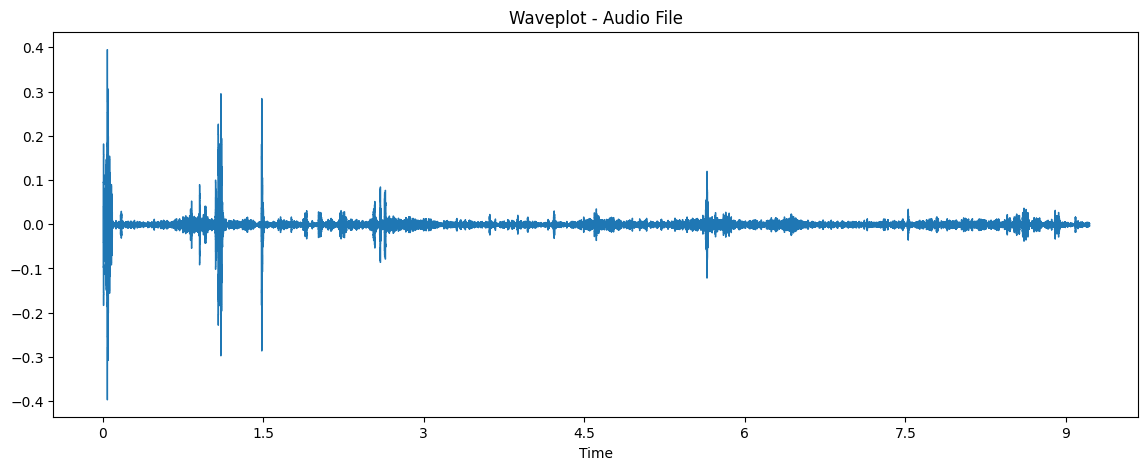

In [19]:
y, sr = librosa.load('/kaggle/input/sprsound-nosplit/SPRSound-main/record/66327579_5.9_1_p3_6380.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

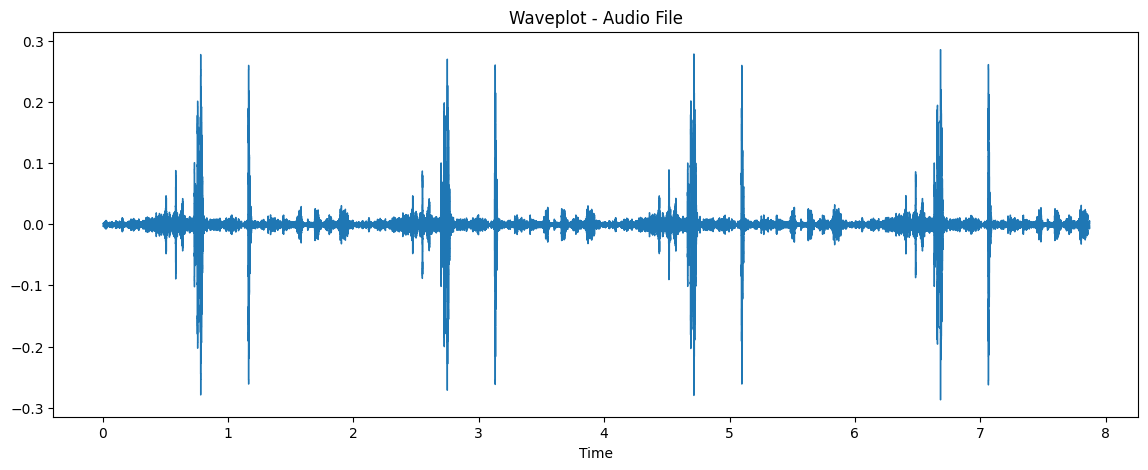

In [20]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S0.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

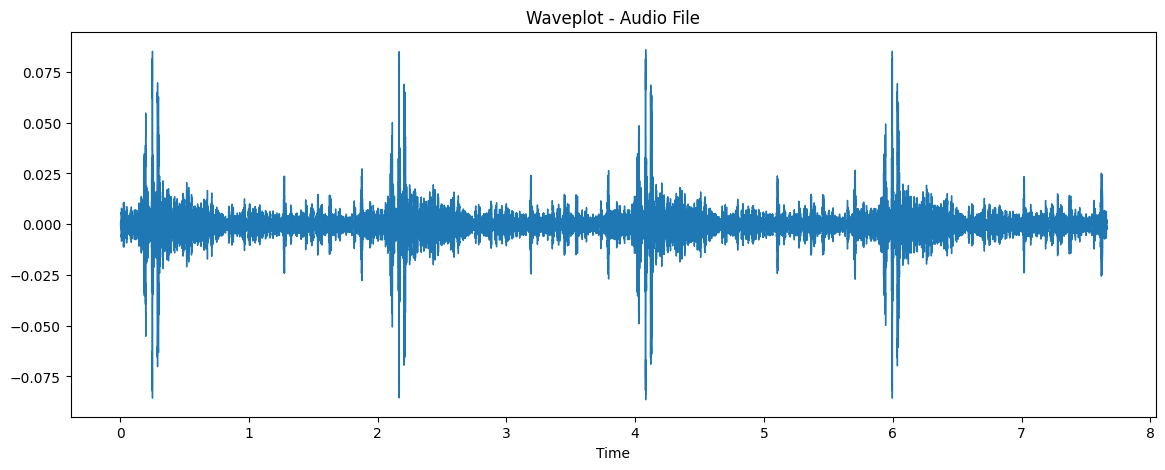

In [21]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S1.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

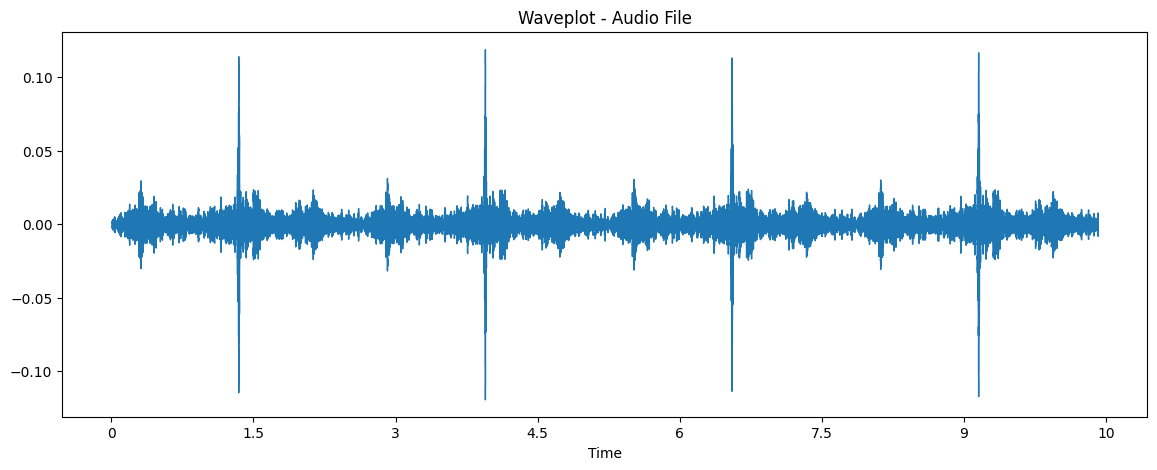

In [22]:
y, sr = librosa.load('/kaggle/working/events/66327579_5.9_1_p3_6380_S2.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

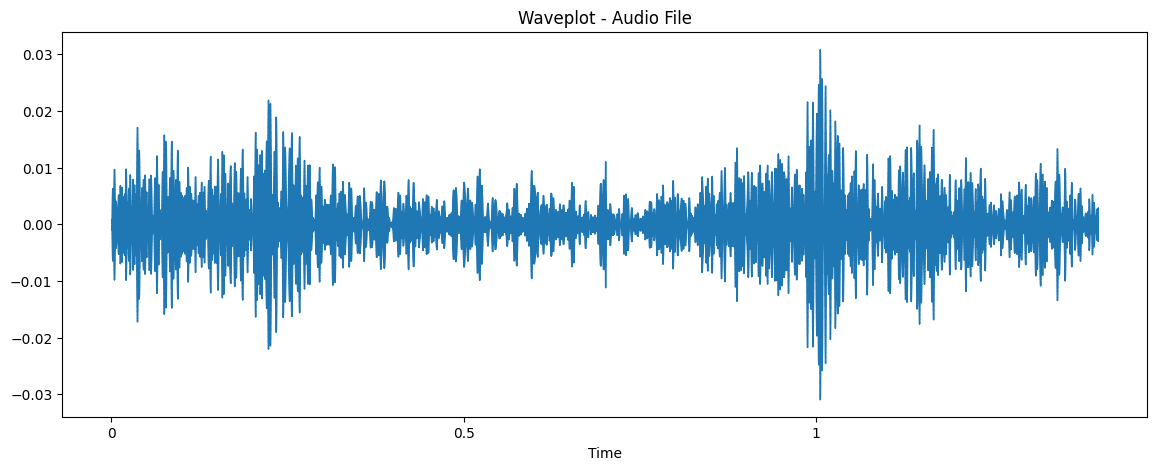

In [23]:
y, sr = librosa.load('/kaggle/working/processed/66327579_5.9_1_p3_6380.wav')

# Plot the audio file
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot - Audio File')
plt.show()

In [47]:
events.to_csv("events_processed.csv")